In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from utils import calc_stable_rank

In [2]:
phi_data = pd.read_json('phi-1.5/phi_stable_rank_data.json')
mpt_data = pd.read_json('mpt-7b/mpt_stable_rank_data.json')

The data that comes out of the `process_data` function is of the form `(layers, heads, 4)`, where each of 4 is the respective weight matrix(they are in the order ['Wq', 'Wk', 'Wv', 'WqWkT']), `heads` is the number of heads in the model, and `layers` is the number of layers in the model. The function retrieves the Stable Rank values for each matrix and returns the Tensor of all the values.

To extract the values for $W_qW_k^T$, for example, do $data[...,-1]$.

In [3]:
def process_data(data, num_layers, num_heads):
    """returns data in the shape (layers, heads, 4)"""
    out_SRs = torch.zeros((num_layers, num_heads, 4)) # (layers, heads, 4)
    for layernum in range(num_layers):
        for w_ind, weight in enumerate(data[f'layer {layernum}'].keys()):
            SRs = torch.Tensor([data[f'layer {layernum}'][weight][head]['stable_rank'] for head in data[f'layer {layernum}'][weight].keys()]) # SR for all 32 heads
            out_SRs[layernum, :, w_ind] += SRs
    return out_SRs

In [4]:
# phi parsing
phi_W_SRs = process_data(phi_data, num_layers=24, num_heads=32) # (layers, heads, 4)
phi_avg_layer_SR = torch.mean(phi_W_SRs, dim=-2)

In [5]:
# mpt parsing
mpt_W_SRs = process_data(mpt_data, num_layers=32, num_heads=32)
mpt_avg_layer_SR = torch.mean(mpt_W_SRs, dim=-2)

In [6]:
def pretty_graph(W_SRs, num_layers, num_heads, model_name="", max_sr=64):
    blue, orange, green, red = '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'
    fig2, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
    for W_num, W in enumerate(['Wq', 'Wk', 'Wv', 'WqWkT']):
        W_data = W_SRs[..., W_num]
        x = [i+1 for i in range(num_layers)]
        y = torch.mean(W_data, dim=-1)
        for layernum,layer in enumerate(W_data):
            x2 = [layernum+1 for _ in range(num_heads)]
            y2 = layer.tolist()
            axes2[W_num%2][W_num//2].scatter(x2, y2, c=blue)
        axes2[W_num%2][W_num//2].plot(x,y, c='k', linewidth=5, label="avg") # average
        axes2[W_num%2][W_num//2].set(title=f"{model_name}: Stable Rank of {W}. (note: the maximum stable rank would be {max_sr})" , xlabel='layer number', ylabel='Stable Rank')
        axes2[W_num%2][W_num//2].axhline(0, c='k')
        axes2[W_num%2][W_num//2].legend()
    plt.tight_layout()
    
    plt.show()

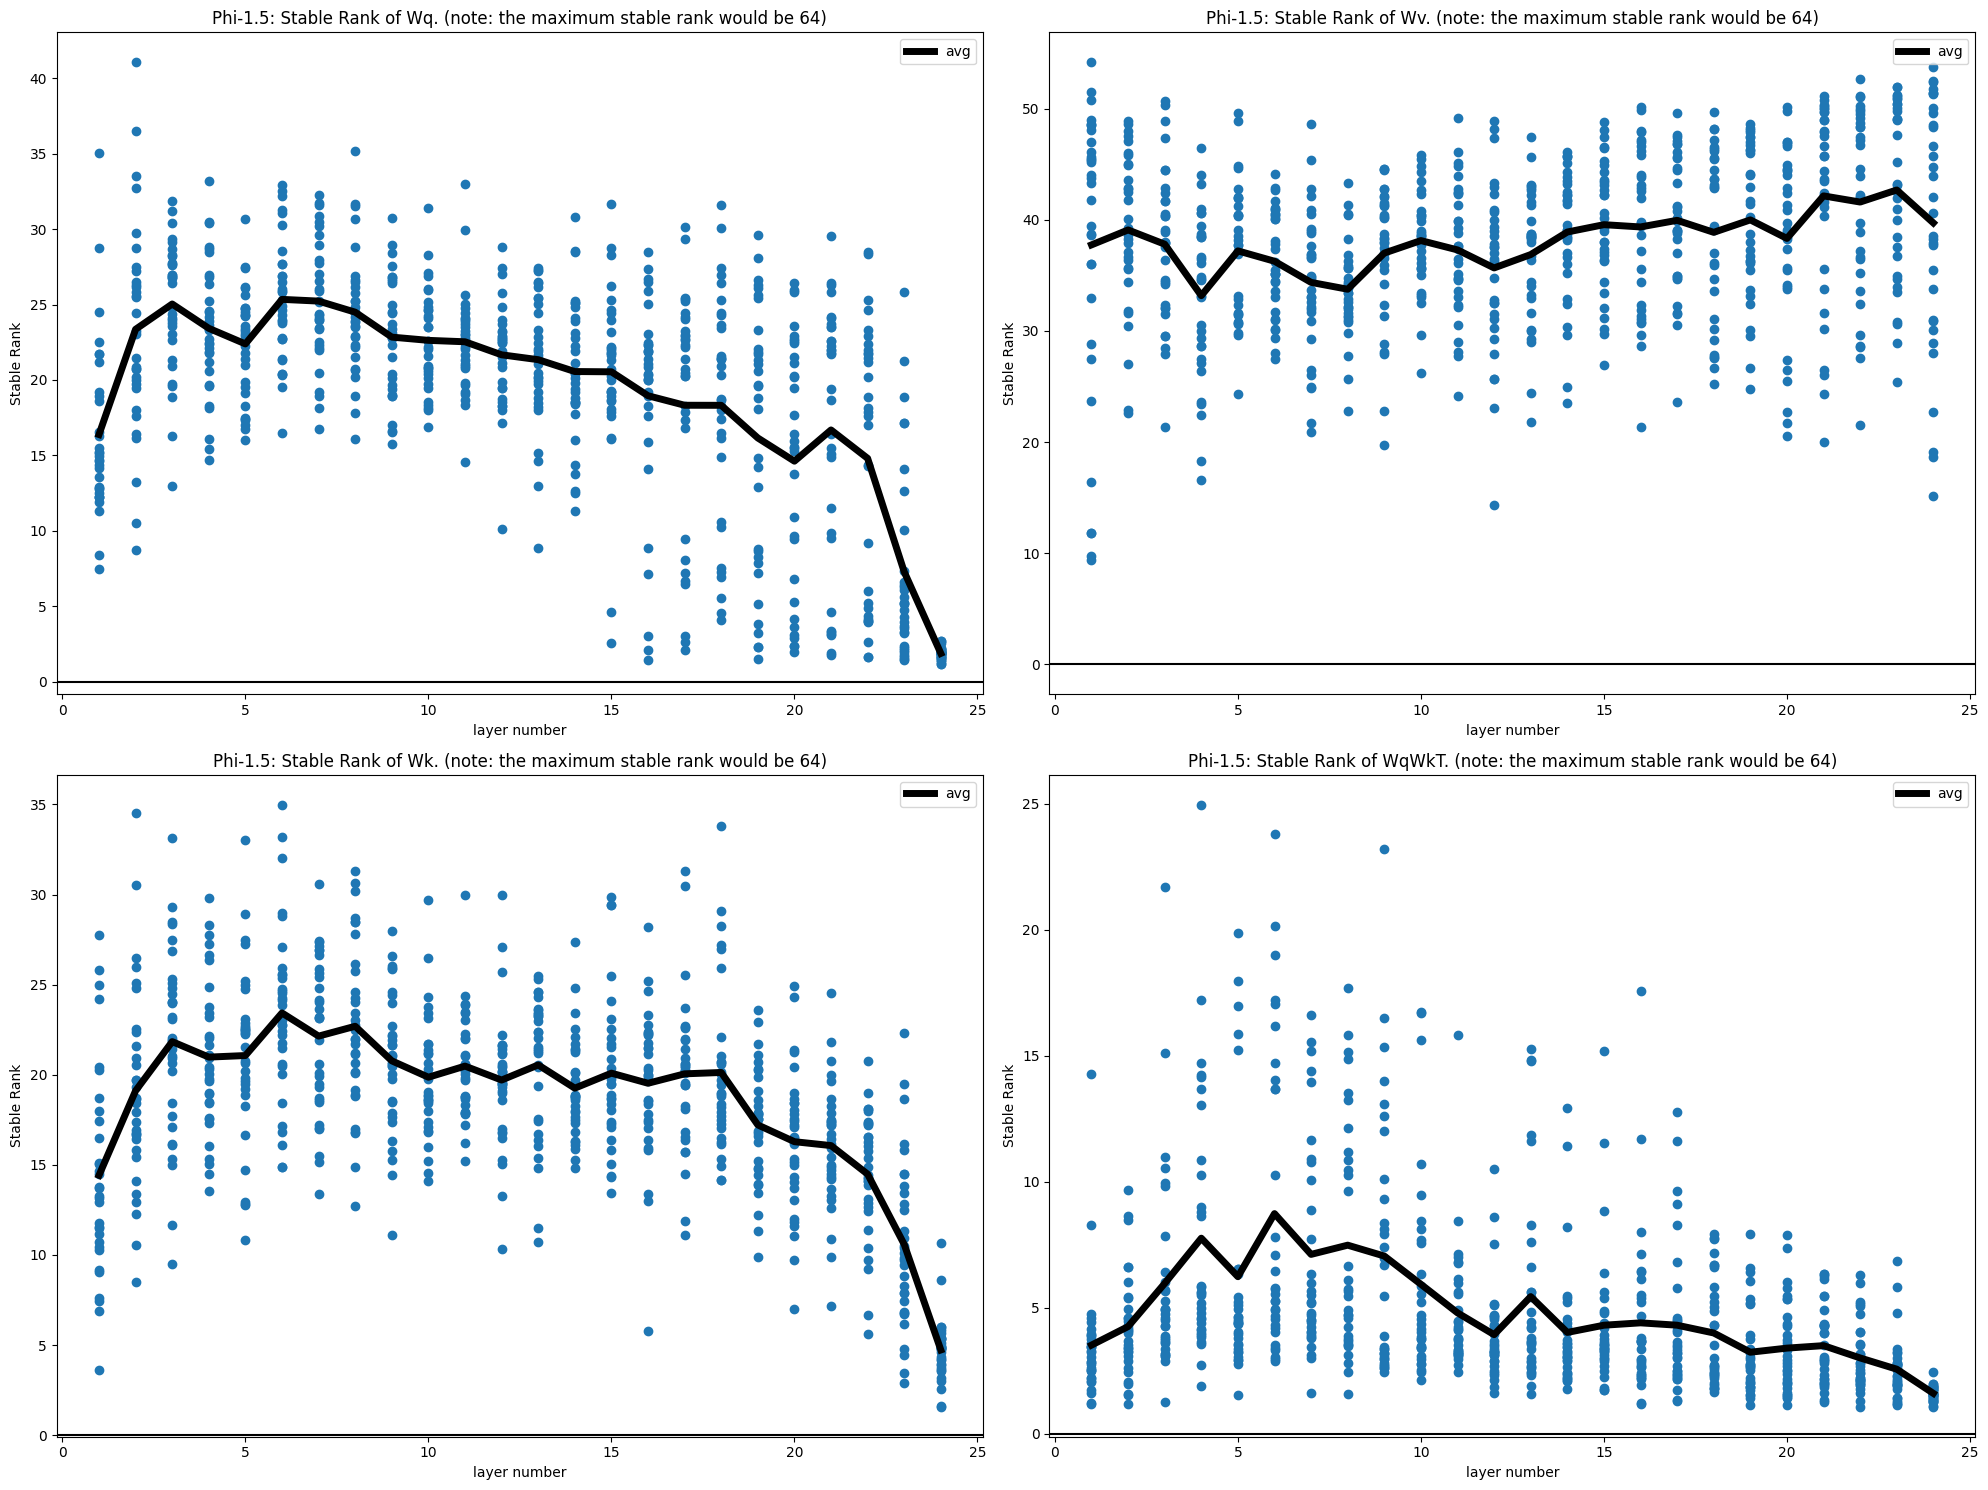

In [7]:
pretty_graph(phi_W_SRs, num_layers=24, num_heads=32, model_name="Phi-1.5", max_sr=64)

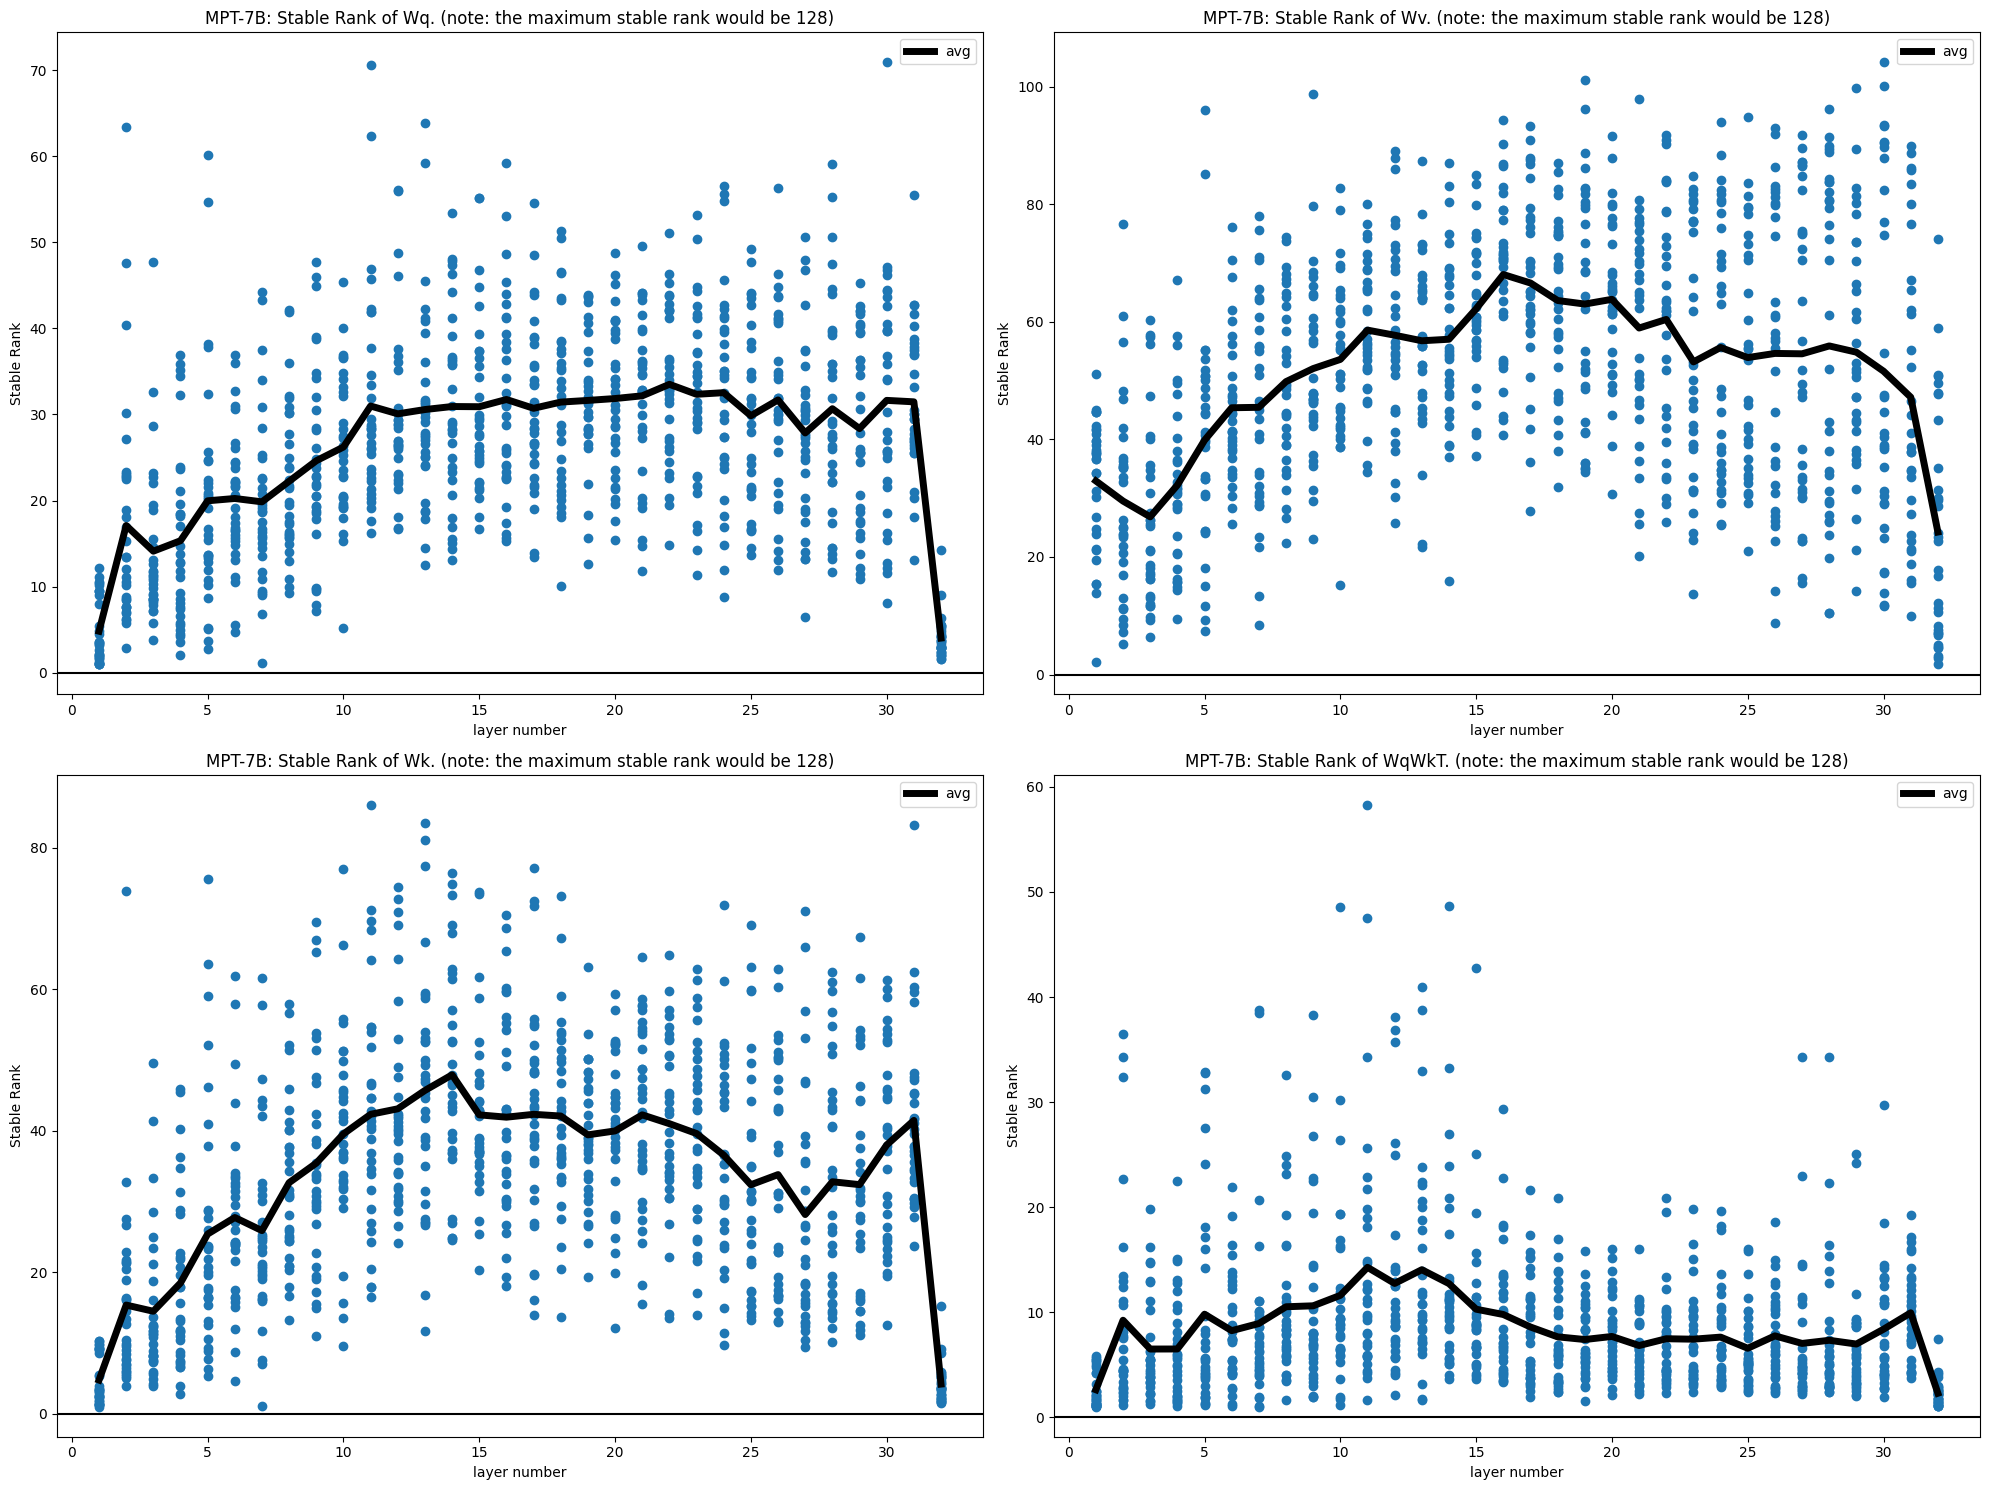

In [8]:
pretty_graph(mpt_W_SRs, num_layers=32, num_heads=32, model_name="MPT-7B", max_sr=128)

In [9]:
def pretty_print_statement(data):
    for layer in data.keys(): 
        for W in data[layer].keys():
            SRs = [round(data[layer][W][head]['stable_rank'], 2) for head in data[layer][W].keys()]
            print(f'{layer},{W}: avg={round(sum(SRs)/len(SRs),2)} <- {SRs}')
        print('\n')

In [10]:
pretty_print_statement(phi_data)

layer 0,Wq: avg=16.38 <- [24.48, 35.05, 18.64, 14.95, 12.83, 28.76, 12.24, 22.54, 14.18, 15.5, 13.56, 11.9, 12.51, 14.62, 21.74, 7.47, 21.22, 16.3, 12.93, 14.68, 12.21, 12.22, 19.17, 21.74, 12.74, 18.93, 15.18, 16.58, 8.37, 15.26, 14.39, 11.31]
layer 0,Wk: avg=14.42 <- [20.43, 27.77, 10.47, 20.25, 11.54, 18.7, 13.29, 17.43, 16.48, 15.05, 13.14, 10.73, 13.77, 9.18, 25.82, 6.91, 24.22, 13.74, 10.29, 14.64, 11.52, 9.06, 14.51, 17.99, 3.63, 24.98, 12.94, 15.09, 7.59, 7.44, 11.75, 11.14]
layer 0,Wv: avg=37.75 <- [54.18, 49.0, 36.03, 45.37, 11.77, 38.69, 46.07, 51.48, 36.02, 48.11, 38.63, 41.79, 48.67, 16.39, 43.35, 9.69, 47.04, 39.49, 48.53, 50.82, 43.74, 45.18, 48.59, 28.82, 32.94, 27.46, 45.43, 44.04, 9.37, 45.7, 23.67, 11.85]
layer 0,WqWkT: avg=3.52 <- [4.61, 3.9, 2.54, 2.11, 2.59, 8.27, 3.62, 4.74, 3.3, 4.45, 3.93, 3.25, 2.51, 2.53, 3.48, 1.61, 2.22, 2.77, 2.07, 4.16, 2.87, 1.21, 2.84, 3.77, 1.19, 14.29, 3.94, 3.45, 2.23, 1.73, 3.43, 3.03]


layer 1,Wq: avg=23.36 <- [25.5, 21.48, 25.6, 

In [11]:
pretty_print_statement(mpt_data)

layer 0,Wq: avg=4.83 <- [12.15, 10.51, 11.14, 9.46, 7.99, 9.52, 10.43, 8.99, 9.45, 10.17, 3.61, 4.88, 5.45, 3.26, 2.62, 4.46, 3.37, 3.47, 1.8, 3.59, 1.19, 2.03, 1.06, 1.54, 1.06, 2.18, 1.05, 2.09, 1.7, 1.25, 1.0, 1.98]
layer 0,Wk: avg=4.75 <- [9.14, 9.32, 8.52, 9.03, 9.34, 9.14, 9.66, 9.88, 10.22, 10.24, 3.45, 5.33, 5.5, 3.2, 2.55, 3.9, 3.3, 3.26, 1.75, 3.51, 1.36, 2.46, 1.21, 1.86, 1.18, 2.53, 1.31, 2.89, 2.25, 1.43, 1.0, 2.37]
layer 0,Wv: avg=32.93 <- [15.34, 23.9, 15.37, 31.17, 19.53, 40.92, 42.21, 44.99, 34.27, 39.77, 13.85, 37.57, 39.05, 41.85, 41.6, 21.16, 36.69, 24.79, 21.38, 34.31, 51.06, 36.67, 37.78, 44.66, 44.64, 38.16, 30.12, 39.79, 44.65, 37.69, 2.05, 26.82]
layer 0,WqWkT: avg=2.61 <- [5.41, 4.2, 4.81, 3.15, 5.8, 4.95, 5.24, 4.24, 5.59, 5.48, 2.08, 2.41, 2.53, 2.45, 1.61, 2.1, 2.01, 1.8, 1.3, 1.58, 1.51, 1.29, 1.27, 1.08, 1.02, 1.82, 1.03, 1.05, 1.27, 1.06, 1.0, 1.32]


layer 1,Wq: avg=17.1 <- [7.62, 12.08, 22.69, 40.45, 16.94, 63.43, 23.09, 22.83, 18.95, 23.36, 30.19, 15.

In [12]:
def latex_table(data):
    table_string = f"Layer & $W_Q$ & $W_K$ & $W_V$ & $W_QW_K^T$ \\\ \n"
    for layernum, layer in enumerate(data.keys()): 
        layer_list = []
        for W in data[layer].keys():
            SRs = [round(data[layer][W][head]['stable_rank'], 2) for head in data[layer][W].keys()]
            W_avg = str(round(sum(SRs)/len(SRs),2))
            layer_list.append(W_avg)
        to_add = " & ".join(layer_list)
        table_string += f'{layernum+1} & {to_add} \\\ \n'
    return table_string

In [13]:
mpt_table_string = latex_table(mpt_data)
print(mpt_table_string)

Layer & $W_Q$ & $W_K$ & $W_V$ & $W_QW_K^T$ \\ 
1 & 4.83 & 4.75 & 32.93 & 2.61 \\ 
2 & 17.1 & 15.36 & 29.51 & 9.23 \\ 
3 & 14.12 & 14.48 & 26.83 & 6.49 \\ 
4 & 15.34 & 18.47 & 32.22 & 6.49 \\ 
5 & 19.97 & 25.39 & 39.85 & 9.8 \\ 
6 & 20.24 & 27.72 & 45.38 & 8.23 \\ 
7 & 19.85 & 25.87 & 45.46 & 8.91 \\ 
8 & 22.24 & 32.65 & 49.82 & 10.51 \\ 
9 & 24.63 & 35.41 & 52.05 & 10.6 \\ 
10 & 26.22 & 39.53 & 53.6 & 11.6 \\ 
11 & 30.98 & 42.31 & 58.59 & 14.26 \\ 
12 & 30.07 & 43.08 & 57.72 & 12.73 \\ 
13 & 30.58 & 45.68 & 56.78 & 14.04 \\ 
14 & 30.93 & 47.89 & 57.03 & 12.71 \\ 
15 & 30.9 & 42.23 & 62.22 & 10.28 \\ 
16 & 31.74 & 41.9 & 68.04 & 9.77 \\ 
17 & 30.72 & 42.31 & 66.6 & 8.58 \\ 
18 & 31.44 & 42.07 & 63.62 & 7.64 \\ 
19 & 31.63 & 39.41 & 63.02 & 7.39 \\ 
20 & 31.85 & 39.96 & 63.83 & 7.68 \\ 
21 & 32.17 & 42.23 & 58.94 & 6.82 \\ 
22 & 33.5 & 40.98 & 60.4 & 7.46 \\ 
23 & 32.35 & 39.59 & 53.18 & 7.42 \\ 
24 & 32.53 & 36.54 & 55.63 & 7.62 \\ 
25 & 29.86 & 32.35 & 53.91 & 6.56 \\ 
26 & 31.69 & 33.

In [14]:
phi_table_string = latex_table(phi_data)
print(phi_table_string)

Layer & $W_Q$ & $W_K$ & $W_V$ & $W_QW_K^T$ \\ 
1 & 16.38 & 14.42 & 37.75 & 3.52 \\ 
2 & 23.36 & 19.11 & 39.09 & 4.26 \\ 
3 & 25.04 & 21.84 & 37.81 & 5.97 \\ 
4 & 23.43 & 20.98 & 33.18 & 7.76 \\ 
5 & 22.39 & 21.07 & 37.21 & 6.24 \\ 
6 & 25.35 & 23.43 & 36.27 & 8.74 \\ 
7 & 25.23 & 22.14 & 34.37 & 7.12 \\ 
8 & 24.5 & 22.69 & 33.75 & 7.49 \\ 
9 & 22.84 & 20.77 & 37.01 & 7.06 \\ 
10 & 22.63 & 19.86 & 38.14 & 5.93 \\ 
11 & 22.53 & 20.48 & 37.3 & 4.8 \\ 
12 & 21.67 & 19.71 & 35.67 & 3.94 \\ 
13 & 21.34 & 20.55 & 36.88 & 5.45 \\ 
14 & 20.56 & 19.26 & 38.9 & 4.02 \\ 
15 & 20.54 & 20.09 & 39.57 & 4.31 \\ 
16 & 18.96 & 19.53 & 39.36 & 4.4 \\ 
17 & 18.32 & 20.05 & 39.96 & 4.31 \\ 
18 & 18.32 & 20.13 & 38.88 & 4.0 \\ 
19 & 16.15 & 17.22 & 40.0 & 3.24 \\ 
20 & 14.62 & 16.29 & 38.33 & 3.4 \\ 
21 & 16.69 & 16.07 & 42.16 & 3.5 \\ 
22 & 14.8 & 14.49 & 41.6 & 3.01 \\ 
23 & 7.27 & 10.59 & 42.69 & 2.57 \\ 
24 & 1.87 & 4.73 & 39.73 & 1.6 \\ 



In [21]:
# random initialization:
# mpt head size:(4096/32)=128 full_emb size: 4096
# phi head size:64 full_emb size: 64*32 = 2048

import torch.nn as nn 
def across_seeds(indim, outdim, seeds):
    avg_sr = 0
    for i in range(seeds):
        torch.manual_seed(i)
        M = nn.Linear(indim, outdim)
        sr,_ = calc_stable_rank(M.weight)
        avg_sr += sr 
    avg_sr /= seeds

    return avg_sr

# phi
print(f'Phi-1.5 random weight initialization across 10 seeds: {round(across_seeds(2048, 64, 10), 2)}')

# mpt
print(f'MPT-7B random weight initialization across 10 seeds: {round(across_seeds(4096, 128, 10), 2)}')

Phi-1.5 random weight initialization across 10 seeds: 46.7
MPT-7B random weight initialization across 10 seeds: 93.29
